In [24]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device Count:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU Only")
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

CUDA Available: True
Device Count: 2
Current Device: 0
Device Name: Tesla T4


In [25]:
import os
print(os.listdir("/kaggle/input/new-busi/archive/Dataset_BUSI_with_GT"))

['benign', 'normal', 'malignant']


In [26]:
import os
import shutil
import random
import numpy as np
from sklearn.model_selection import train_test_split

# Define the dataset path
DATASET_PATH = "/kaggle/input/new-busi/archive/Dataset_BUSI_with_GT" #Raw Dataset
OUTPUT_PATH = "/kaggle/working/output" #Train/Test Data will be saved


# Define categories
CATEGORIES = ["normal", "benign", "malignant"] #normal - no tumor,benign - non-cancerous,malignant - cancerous

# Create directories for train and test datasets
for split in ["train", "test"]:
    for category in CATEGORIES:
        os.makedirs(os.path.join(OUTPUT_PATH, split, category), exist_ok=True) #/train/benign,/train/malignant,/train/normal
        os.makedirs(os.path.join(OUTPUT_PATH, split, category + "_masks"), exist_ok=True) #/train/benign_masks,/train/malignant_masks,/train/normal_masks

# Dictionary to store image and mask paths
image_data = {category: [] for category in CATEGORIES}

# Iterate through each category and load image-mask pairs
for category in CATEGORIES:
    category_path = os.path.join(DATASET_PATH, category)
    images = sorted([f for f in os.listdir(category_path) if f.endswith(".png") and "_mask" not in f]) #Finds all images excluding masks in all the categories

    for img in images:
        img_path = os.path.join(category_path, img)#Generate image path
        mask_path = os.path.join(category_path, img.replace(".png", "_mask.png"))  # Ensure correct mask pairing
        
        # Check if the corresponding mask exists
        if os.path.exists(mask_path):
            image_data[category].append((img_path, mask_path))
        else:
            print(f"Warning: Missing mask for {img_path}")

train_data = {}
test_data = {}

# Split each category separately
for category in CATEGORIES:
    train_imgs, test_imgs = train_test_split(
    image_data[category], test_size=0.2, random_state=42, stratify=None if len(image_data[category]) < 2 else [category] * len(image_data[category])
)
    train_data[category] = train_imgs
    test_data[category] = test_imgs

# Function to move images and masks to respective directories
def move_files(data, split):#
    for category, img_list in data.items(): #Loop over train or test data
        for img_path, mask_path in img_list:
            img_filename = os.path.basename(img_path)
            mask_filename = os.path.basename(mask_path)

            # Define destination paths
            dest_img = os.path.join(OUTPUT_PATH, split, category, img_filename)
            dest_mask = os.path.join(OUTPUT_PATH, split, category + "_masks", mask_filename)

            # Copy files to new location
            shutil.copy2(img_path, dest_img)
            shutil.copy2(mask_path, dest_mask)

# Move training and testing data
move_files(train_data, "train")
move_files(test_data, "test")

print("Dataset preparation completed successfully!")

Dataset preparation completed successfully!


In [27]:
import cv2
import os
import numpy as np
from tqdm import tqdm

# Define paths
INPUT_PATH = "/kaggle/working/output/train"
OUTPUT_PATH = "/kaggle/working/preprocessed_output/train"

CATEGORIES = ["normal", "benign", "malignant"]

# Create directories for preprocessed images
for category in CATEGORIES:
    os.makedirs(os.path.join(OUTPUT_PATH, category), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_PATH, category + "_masks"), exist_ok=True)

def preprocess_image(image_path):
    image = cv2.imread(image_path)

    if image is None:  # Handle missing or unreadable files
        print(f"Warning: Could not read {image_path}")
        return None

    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Apply median filtering to reduce noise
    blurred = cv2.medianBlur(gray, 5)

    # Apply binary thresholding to segment the breast region
    edges = cv2.Canny(blurred, 50, 150)
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 50, param1=50, param2=30, minRadius=20, maxRadius=100)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        xc, yc, r = circles[0][0]  # Take the first detected circle
    else:
        return image  # Return original if no circle is found

    # Step 2: Find Subject Contours
    _, binary = cv2.threshold(blurred, 30, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return image  # Return original if no contours found

    # Get the largest contour (assuming it is the breast/tumor)
    contour = max(contours, key=cv2.contourArea)

    # Step 3: Identify Extreme Points (Leftmost, Rightmost, Bottommost)
    leftmost = tuple(contour[contour[:, :, 0].argmin()][0])
    rightmost = tuple(contour[contour[:, :, 0].argmax()][0])
    bottommost = tuple(contour[contour[:, :, 1].argmax()][0])

    # Compute Radius of Outer Circle
    R = max(abs(xc - leftmost[0]), abs(xc - rightmost[0])) + abs(yc - bottommost[1]) // 2

    # Step 4: Define Sector Mask (30° to 150°)
    theta_min, theta_max = np.deg2rad(30), np.deg2rad(150)
    mask = np.zeros_like(gray)
    cv2.ellipse(mask, (xc, yc), (R, R), 0, 30, 150, 255, -1)

    # Apply Mask to Extract Sector
    roi = cv2.bitwise_and(gray, gray, mask=mask)

    # Step 5: Convert Sector to Rectangular using Polar Transformation
    h, w = 224, 224  # Define output size
    rectified_roi = np.zeros((h, w), dtype=np.uint8)

    for i in range(h):
        for j in range(w):
            # Convert rectangular coordinates to polar
            r = int(R * (i / h))  # Radius scaling
            theta = theta_min + (theta_max - theta_min) * (j / w)  # Angle scaling

            # Convert polar to Cartesian
            x = int(xc + r * np.cos(theta))
            y = int(yc + r * np.sin(theta))

            # Assign pixel values
            if 0 <= x < gray.shape[1] and 0 <= y < gray.shape[0]:
                rectified_roi[i, j] = roi[y, x]

    return rectified_roi
    
def preprocess_mask(mask_path):
    """
    Simply resizes the mask without extracting ROI.
    """
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        print(f"Warning: Could not read mask {mask_path}")
        return None

    return cv2.resize(mask, (224, 224))  # Direct resize without ROI extraction

for category in CATEGORIES:
    input_folder = os.path.join(INPUT_PATH, category)
    output_folder = os.path.join(OUTPUT_PATH, category)

    # Process each image
    for filename in tqdm(os.listdir(input_folder), desc=f"Processing {category}"):
        img_path = os.path.join(input_folder, filename)
        preprocessed_img = preprocess_image(img_path)

        if preprocessed_img is not None:
            output_img_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_img_path, preprocessed_img)
        else:
            print(f"Warning: No ROI detected in {filename}")

for category in CATEGORIES:
    mask_input_folder = os.path.join(INPUT_PATH, category + "_masks")
    mask_output_folder = os.path.join(OUTPUT_PATH, category + "_masks")

    # Process each mask
    for filename in tqdm(os.listdir(mask_input_folder), desc=f"Processing masks for {category}"):
        mask_path = os.path.join(mask_input_folder, filename)
        preprocessed_mask = preprocess_image(mask_path)

        if preprocessed_mask is not None:
            output_mask_path = os.path.join(mask_output_folder, filename)
            cv2.imwrite(output_mask_path, preprocessed_mask)

Processing masks for malignant: 100%|██████████| 168/168 [00:01<00:00, 93.42it/s]


In [28]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import random

class BUSIDataset(Dataset):
    """
    Custom dataset class for loading BUSI dataset with augmentations.
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        self.class_map = {"normal": 0, "benign": 1, "malignant": 2}
        # Load all images from normal, benign, malignant categories
        for category in ["normal", "benign", "malignant"]:
            category_path = os.path.join(root_dir, category)
            for filename in os.listdir(category_path):
                if filename.endswith(".png"):
                    self.image_paths.append(os.path.join(category_path, filename))
                    self.labels.append(self.class_map[category])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure RGB format
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image,label


transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images randomly
    transforms.RandomRotation(15),  # Rotate images up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Improve contrast
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the dataset
train_dataset = BUSIDataset(root_dir="/kaggle/working/preprocessed_output/train", transform=transform_train)
#train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for images, labels in train_loader:
    print(f"Batch Image Shape: {images.shape}")  # Should be (32, 3, 224, 224)
    print(f"Batch Labels: {labels}")  # Should print label tensor
    break  # Stop after one batch

Batch Image Shape: torch.Size([32, 3, 224, 224])
Batch Labels: tensor([1, 1, 2, 2, 0, 2, 0, 2, 0, 0, 2, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 0,
        1, 1, 0, 0, 0, 1, 1, 1])


In [29]:
from torchvision.models.vision_transformer import vit_b_16

class ViTEncoder(nn.Module):
    def __init__(self):
        super(ViTEncoder, self).__init__()
        self.vit = vit_b_16(weights=None)  # Load ViT model without pretrained weights
        self.vit.heads = nn.Identity()  # Remove classification head

    def forward(self, x):
        x = self.vit.conv_proj(x)  # Convert images into ViT patch embeddings
        x = x.flatten(2).transpose(1, 2)  # Reshape for transformer
        n = x.shape[0]  # Batch size
        batch_class_token = self.vit.class_token.expand(n, -1, -1)  # Expand class token
        x = torch.cat([batch_class_token, x], dim=1)  # Concatenate class token
        x = self.vit.encoder(x)  # Pass through transformer encoder
        return x  # Output shape: (batch_size, num_patches, hidden_dim)

In [36]:
class MaskedAutoencoder(nn.Module):
    """
    MAE: Learns by reconstructing masked parts of the input image.
    """
    def __init__(self, encoder, mask_ratio=0.75):
        super(MaskedAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder_input_dim = 768  # ViT's hidden size

        # Decoder with correct output size (224x224)
        self.decoder = nn.Sequential(
            nn.Linear(self.decoder_input_dim, 1024),  # Expand feature size
            nn.LayerNorm(1024),  # Stabilize training
            nn.ReLU(),
            nn.Linear(1024, 14 * 14 * 768),  # Adjust based on ViT patches (14x14)
            nn.ReLU(),
            nn.Unflatten(1, (768, 14, 14)),  # Match ViT feature map
            
            nn.ConvTranspose2d(768, 256, kernel_size=4, stride=2, padding=1),  # (256, 28, 28)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # (128, 56, 56)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 112, 112)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (32, 224, 224)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),  # (3, 224, 224)
            nn.Sigmoid()  # Normalize output between 0 and 1
        )

        self.mask_ratio = mask_ratio

    def forward(self, x):
        batch_size, channels, height, width = x.shape
    
        # Create a mask for patches, not raw pixels
        mask = torch.rand(batch_size, 1, height, width).to(x.device) > self.mask_ratio
        x_masked = x * mask  # Apply mask to raw images
    
        # Convert masked image to ViT patch embeddings
        patch_embeddings = self.encoder.vit.conv_proj(x_masked)  # (batch_size, hidden_dim, 14, 14)
        patch_embeddings = patch_embeddings.flatten(2).transpose(1, 2)  # Reshape to (batch_size, 196, hidden_dim)
    
        # Add [CLS] token
        cls_token = self.encoder.vit.class_token.expand(batch_size, -1, -1)  # (batch_size, 1, hidden_dim)
        patch_embeddings = torch.cat([cls_token, patch_embeddings], dim=1)  # (batch_size, 197, hidden_dim)
    
        # Encode masked image patches
        encoded = self.encoder.vit.encoder(patch_embeddings)  # ✅ Correct input shape
    
        # Decode & reconstruct the image
        reconstructed = self.decoder(encoded.mean(dim=1))  # Decode the averaged representation
        return reconstructed, mask

In [ ]:
import torch
import torch.nn as nn

class ContrastiveLearning(nn.Module):
    def __init__(self, encoder, queue_size=1024, temperature=0.07, momentum=0.999):
        super(ContrastiveLearning, self).__init__()
        self.encoder_q = encoder  
        self.encoder_k = encoder 
        self.temperature = temperature
        self.queue_size = queue_size
        self.momentum = momentum

        
        self.register_buffer("queue", torch.randn(queue_size, 768))
        self.queue = nn.functional.normalize(self.queue, dim=1)  

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)  
            param_k.requires_grad = False 

    @torch.no_grad()
    def update_momentum_encoder(self):
        
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = self.momentum * param_k.data + (1 - self.momentum) * param_q.data

    def forward(self, x_q, x_k):

        q = self.encoder_q(x_q) 
        k = self.encoder_k(x_k)  
        
        q = q[:, 0, :]  
        k = k[:, 0, :]  

        
        q = nn.functional.normalize(q, dim=1)
        k = nn.functional.normalize(k, dim=1)

        
        logits = torch.mm(q, self.queue.T) / self.temperature  
        labels = torch.arange(q.shape[0], dtype=torch.long, device=q.device)

        self.queue = torch.cat((k.detach(), self.queue[:-k.shape[0]]), dim=0)  
        self.update_momentum_encoder()

        return logits, labels


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import torch.backends.cudnn as cudnn
from torch.amp import GradScaler, autocast  

cudnn.benchmark = True 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") 

encoder = ViTEncoder().to(device)

for param in encoder.vit.parameters():
    param.requires_grad = False  
for param in encoder.vit.encoder.layers[-2:]:  
    param.requires_grad = True

mae_model = MaskedAutoencoder(encoder).to(device)
contrastive_model = ContrastiveLearning(encoder).to(device)

reconstruction_loss_fn = nn.MSELoss()
contrastive_loss_fn = nn.CrossEntropyLoss()

optimizer_mae = optim.AdamW(mae_model.parameters(), lr=1e-4)
optimizer_contrastive = optim.AdamW(contrastive_model.parameters(), lr=1e-4)

scheduler_mae = optim.lr_scheduler.StepLR(optimizer_mae, step_size=5, gamma=0.7)
scheduler_contrastive = optim.lr_scheduler.StepLR(optimizer_contrastive, step_size=5, gamma=0.7)

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(15),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

to_pil = transforms.ToPILImage()  

num_epochs = 50
scaler = GradScaler()  

for epoch in range(num_epochs):
    mae_model.train()
    contrastive_model.train()

    total_recon_loss = 0.0
    total_contrastive_loss = 0.0

    for images, _ in train_loader:  
        images = images.to(device)  

        x_q = torch.stack([transform_train(to_pil(img)) for img in images]).to(device)
        x_k = torch.stack([transform_train(to_pil(img)) for img in images]).to(device)

        
        with autocast(device_type=device.type):
            reconstructed,_ = mae_model(images)
            recon_loss = reconstruction_loss_fn(reconstructed, images)

            logits, labels = contrastive_model(x_q, x_k)
            contrastive_loss = contrastive_loss_fn(logits, labels)

            total_loss = recon_loss + contrastive_loss
        optimizer_mae.zero_grad()
        optimizer_contrastive.zero_grad()
        scaler.scale(total_loss).backward()

        if any(p.grad is not None for p in mae_model.parameters()):
            scaler.step(optimizer_mae)
        if any(p.grad is not None for p in contrastive_model.parameters()):
            scaler.step(optimizer_contrastive)

        scaler.update()

        total_recon_loss += recon_loss.item()
        total_contrastive_loss += contrastive_loss.item()

    scheduler_mae.step()
    scheduler_contrastive.step()

    print(f"Epoch {epoch+1}/{num_epochs} - Reconstruction Loss: {total_recon_loss:.4f}, Contrastive Loss: {total_contrastive_loss:.4f}")

torch.save(encoder.state_dict(), "/kaggle/working/vit_encoder.pth")
print("Self-Supervised Pretraining Completed! ✅")


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/50 - Reconstruction Loss: 25.8911, Contrastive Loss: 119.7325
Epoch 2/50 - Reconstruction Loss: 12.4119, Contrastive Loss: 143.9042
Epoch 3/50 - Reconstruction Loss: 11.9570, Contrastive Loss: 144.7642
Epoch 4/50 - Reconstruction Loss: 11.8910, Contrastive Loss: 146.4914
Epoch 5/50 - Reconstruction Loss: 11.8776, Contrastive Loss: 146.2334
Epoch 6/50 - Reconstruction Loss: 11.9053, Contrastive Loss: 145.4461
Epoch 7/50 - Reconstruction Loss: 11.9057, Contrastive Loss: 145.6965
Epoch 8/50 - Reconstruction Loss: 11.9015, Contrastive Loss: 144.9009
Epoch 9/50 - Reconstruction Loss: 11.8974, Contrastive Loss: 144.6406
Epoch 10/50 - Reconstruction Loss: 11.8898, Contrastive Loss: 145.4475
Epoch 11/50 - Reconstruction Loss: 11.8705, Contrastive Loss: 146.0449
Epoch 12/50 - Reconstruction Loss: 11.8861, Contrastive Loss: 145.3875
Epoch 13/50 - Reconstruction Loss: 11.9576, Contrastive Loss: 146.8110
Epoch 14/50 - Reconstruction Loss: 11.9419, Contrastive Loss: 147.0297
Epoch 15/50 - R

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the pre-trained ViT encoder from Phase 3
class ViTClassifier(nn.Module):
    def __init__(self, pretrained_encoder, num_classes=3):
        super(ViTClassifier, self).__init__()
        self.encoder = pretrained_encoder  # Pretrained ViT from Phase 3
        self.classifier = nn.Sequential(
                            nn.Linear(768, 512),
                            nn.ReLU(),
                            nn.Linear(512, num_classes),
                            nn.Dropout(0.3),  # Reduce overfitting
        )

    def forward(self, x):
        features = self.encoder(x)  # Extract features
        features = features[:, 0, :]  # Use only the CLS token
        output = self.classifier(features)  # Predict class
        return output

In [45]:
# Load the ViT Encoder with Safe Mode
encoder = ViTEncoder()  # Reinitialize model
encoder.load_state_dict(torch.load("/kaggle/working/vit_encoder.pth", weights_only=True))  
encoder.to(device)
encoder.eval()  # Set to evaluation mode

print("✅ ViT Encoder Loaded Successfully (Safe Mode)!")

✅ ViT Encoder Loaded Successfully (Safe Mode)!


In [47]:
classifier_model = ViTClassifier(encoder).to(device)

In [49]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Improve contrast
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

# Manually define class mapping
class_mapping = {"benign": 0, "benign_masks": 0, 
                 "malignant": 1, "malignant_masks": 1, 
                 "normal": 2, "normal_masks": 2}

# Custom dataset to merge mask images into the same class as the main category
class MergedImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)

        # Map all images to correct labels
        new_samples = []
        for path, label in self.samples:
            folder_name = path.split(os.sep)[-2]  # Get folder name (e.g., benign_masks)
            if folder_name in class_mapping:
                new_label = class_mapping[folder_name]  # Assign the correct label
                new_samples.append((path, new_label))

        # Overwrite the dataset samples with the corrected version
        self.samples = new_samples
        self.targets = [label for _, label in self.samples]

# Load dataset
train_dataset = MergedImageFolder(root="/kaggle/working/output/train", transform=transform)
test_dataset = MergedImageFolder(root="/kaggle/working/output/test", transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print class mapping
print("Class Mapping:", {c: class_mapping[c] for c in sorted(class_mapping.keys())})

Class Mapping: {'benign': 0, 'benign_masks': 0, 'malignant': 1, 'malignant_masks': 1, 'normal': 2, 'normal_masks': 2}


In [50]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = nn.functional.cross_entropy(logits, targets, reduction="none")
        p_t = torch.exp(-ce_loss)  # Probabilities of the true class
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss

        return focal_loss.mean() if self.reduction == "mean" else focal_loss.sum()

In [ ]:
# Define Loss & Optimizer
criterion = FocalLoss(alpha=0.25, gamma=2) # Multi-class classification
optimizer = optim.AdamW(classifier_model.parameters(), lr=1e-4)

# Add Learning Rate Scheduler (reduces LR every 5 epochs)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    classifier_model.train()
    total_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier_model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = outputs.softmax(dim=1).argmax(dim=1) 
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Step the scheduler after each epoch
    scheduler.step()

    accuracy = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}")

# Save the trained classifier
torch.save(classifier_model.state_dict(), "/kaggle/working/fine_tuned_vit_classifier.pth")
print("Training Completed! ✅")


Epoch 1/50, Loss: 4.3605, Accuracy: 53.45%, LR: 0.000100
Epoch 2/50, Loss: 3.6438, Accuracy: 60.43%, LR: 0.000100
Epoch 3/50, Loss: 3.6993, Accuracy: 56.66%, LR: 0.000100
Epoch 4/50, Loss: 3.5086, Accuracy: 59.23%, LR: 0.000100
Epoch 5/50, Loss: 3.1116, Accuracy: 61.80%, LR: 0.000070
Epoch 6/50, Loss: 3.1396, Accuracy: 62.60%, LR: 0.000070
Epoch 7/50, Loss: 3.1449, Accuracy: 62.52%, LR: 0.000070
Epoch 8/50, Loss: 3.1622, Accuracy: 61.80%, LR: 0.000070
Epoch 9/50, Loss: 2.9867, Accuracy: 62.92%, LR: 0.000070
Epoch 10/50, Loss: 3.0066, Accuracy: 63.00%, LR: 0.000049
Epoch 11/50, Loss: 2.8612, Accuracy: 65.41%, LR: 0.000049
Epoch 12/50, Loss: 2.7766, Accuracy: 66.77%, LR: 0.000049
Epoch 13/50, Loss: 2.6018, Accuracy: 69.74%, LR: 0.000049
Epoch 14/50, Loss: 2.7130, Accuracy: 70.14%, LR: 0.000049
Epoch 15/50, Loss: 2.4675, Accuracy: 71.67%, LR: 0.000034
Epoch 16/50, Loss: 2.2300, Accuracy: 74.96%, LR: 0.000034
Epoch 17/50, Loss: 2.2006, Accuracy: 73.11%, LR: 0.000034
Epoch 18/50, Loss: 2.14

In [52]:
# Load the trained model for evaluation
classifier_model.load_state_dict(torch.load("/kaggle/working/fine_tuned_vit_classifier.pth",weights_only=True))
classifier_model.eval()

ViTClassifier(
  (encoder): ViTEncoder(
    (vit): VisionTransformer(
      (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (encoder): Encoder(
        (dropout): Dropout(p=0.0, inplace=False)
        (layers): Sequential(
          (encoder_layer_0): EncoderBlock(
            (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (self_attention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
            (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): MLPBlock(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.0, inplace=False)
              (3): Linear(in_features=3072, out_features=768, bias=True)
              (4): Dropout(p=0.0, inplace=False)
            )
         

In [53]:
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier_model(images)
        predicted = outputs.softmax(dim=1).argmax(dim=1)


        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average="weighted") * 100
recall = recall_score(y_true, y_pred, average="weighted") * 100
f1 = f1_score(y_true, y_pred, average="weighted") * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

Accuracy: 79.62%
Precision: 79.71%
Recall: 79.62%
F1 Score: 79.14%


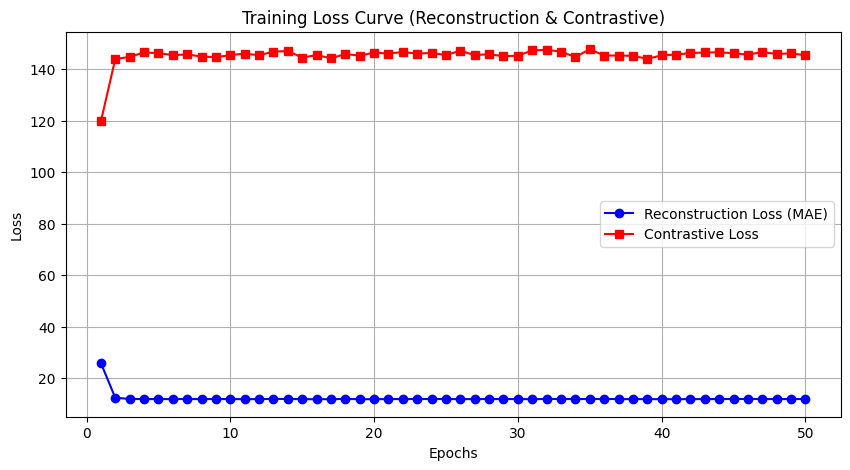

In [58]:
import matplotlib.pyplot as plt

# Extract loss values from logs
reconstruction_losses = [
    25.8911, 12.4119, 11.9570, 11.8910, 11.8776, 11.9053, 11.9057, 11.9015, 11.8974, 11.8898,
    11.8705, 11.8861, 11.9576, 11.9419, 11.8666, 11.8425, 11.8591, 11.9490, 11.8564, 11.8448,
    11.9009, 11.8985, 11.9235, 11.9173, 11.9169, 11.8737, 11.8900, 11.9146, 11.8914, 11.9115,
    11.8404, 11.9468, 11.9176, 11.9226, 11.9097, 11.9378, 11.9003, 11.8689, 11.8889, 11.8519,
    11.8565, 11.8873, 11.8794, 11.9135, 11.9253, 11.9490, 11.9080, 11.8927, 11.9092, 11.9243
]

contrastive_losses = [
    119.7325, 143.9042, 144.7642, 146.4914, 146.2334, 145.4461, 145.6965, 144.9009, 144.6406, 145.4475,
    146.0449, 145.3875, 146.8110, 147.0297, 144.4936, 145.4469, 144.2388, 145.8363, 145.2704, 146.4045,
    146.0306, 146.6602, 146.0206, 146.2957, 145.4741, 147.1364, 145.4647, 145.7974, 145.0030, 145.2256,
    147.2697, 147.5175, 146.8016, 144.7004, 147.7377, 145.2839, 145.2819, 145.1857, 144.0220, 145.3436,
    145.6719, 146.2311, 146.4828, 146.5170, 146.2176, 145.6028, 146.6679, 145.8774, 146.1429, 145.3653
]

epochs = range(1, 51)  # Epoch numbers (1 to 50)

# Plot Reconstruction & Contrastive Losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, reconstruction_losses, label="Reconstruction Loss (MAE)", marker="o", linestyle="-", color="blue")
plt.plot(epochs, contrastive_losses, label="Contrastive Loss", marker="s", linestyle="-", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve (Reconstruction & Contrastive)")
plt.legend()
plt.grid(True)
plt.show()


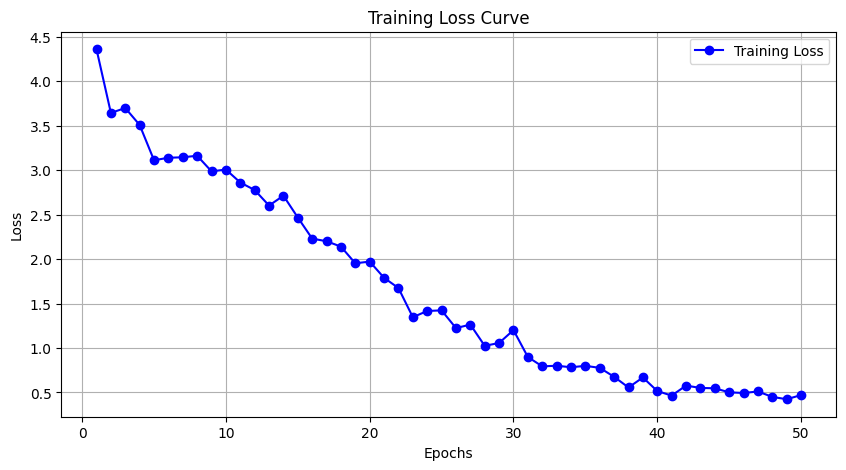

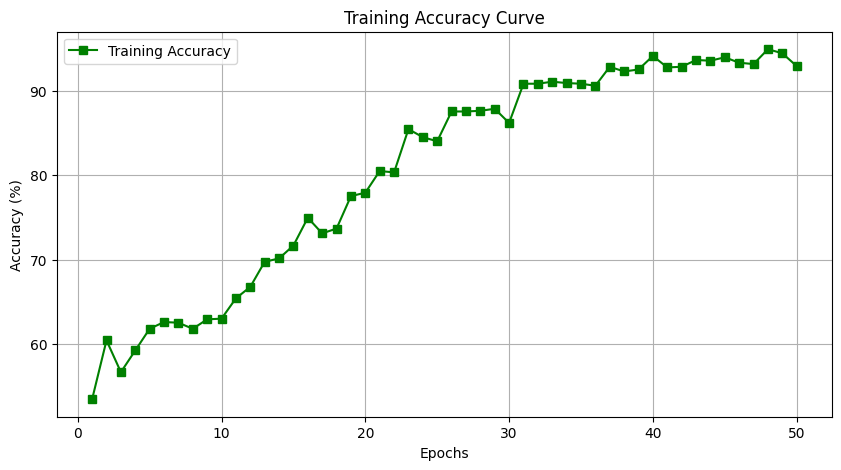

In [59]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values from logs
loss_values = [
    4.3605, 3.6438, 3.6993, 3.5086, 3.1116, 3.1396, 3.1449, 3.1622, 2.9867, 3.0066,
    2.8612, 2.7766, 2.6018, 2.7130, 2.4675, 2.2300, 2.2006, 2.1400, 1.9522, 1.9718,
    1.7891, 1.6740, 1.3461, 1.4160, 1.4229, 1.2235, 1.2629, 1.0239, 1.0562, 1.2010,
    0.8983, 0.7931, 0.8001, 0.7831, 0.7988, 0.7763, 0.6754, 0.5555, 0.6680, 0.5155,
    0.4642, 0.5765, 0.5504, 0.5465, 0.5009, 0.4936, 0.5103, 0.4496, 0.4234, 0.4700
]

accuracy_values = [
    53.45, 60.43, 56.66, 59.23, 61.80, 62.60, 62.52, 61.80, 62.92, 63.00,
    65.41, 66.77, 69.74, 70.14, 71.67, 74.96, 73.11, 73.68, 77.53, 77.93,
    80.50, 80.34, 85.47, 84.51, 84.03, 87.56, 87.56, 87.64, 87.88, 86.20,
    90.85, 90.85, 91.09, 90.93, 90.85, 90.61, 92.86, 92.30, 92.54, 94.14,
    92.78, 92.86, 93.66, 93.58, 93.98, 93.34, 93.18, 94.94, 94.46, 92.94
]

epochs = range(1, 51)  # Epoch numbers (1 to 50)

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, label="Training Loss", marker="o", linestyle="-", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy_values, label="Training Accuracy", marker="s", linestyle="-", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()


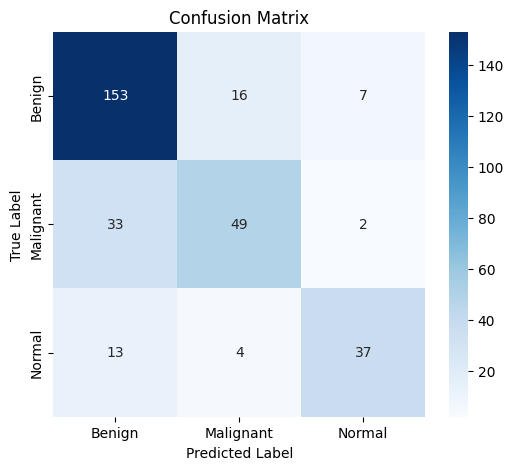

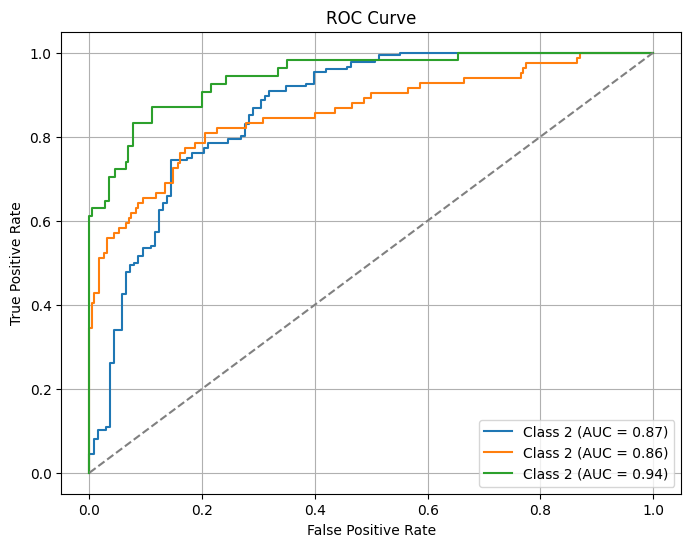

In [60]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ----------------------- CONFUSION MATRIX -----------------------

# Load test data and model predictions
y_true = []  # True labels from test set
y_pred = []  # Model's predicted labels

classifier_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier_model(images)
        predicted = outputs.softmax(dim=1).argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = ["Benign", "Malignant", "Normal"]  # Adjust for your dataset

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ----------------------- ROC CURVE -----------------------

# Convert labels to one-hot encoding
num_classes = len(set(y_true))  # Number of classes
y_true_bin = label_binarize(y_true, classes=range(num_classes))

# Get model prediction probabilities
y_pred_prob = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = classifier_model(images)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
        y_pred_prob.extend(probabilities)

y_pred_prob = np.array(y_pred_prob)  # Convert list to numpy array

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


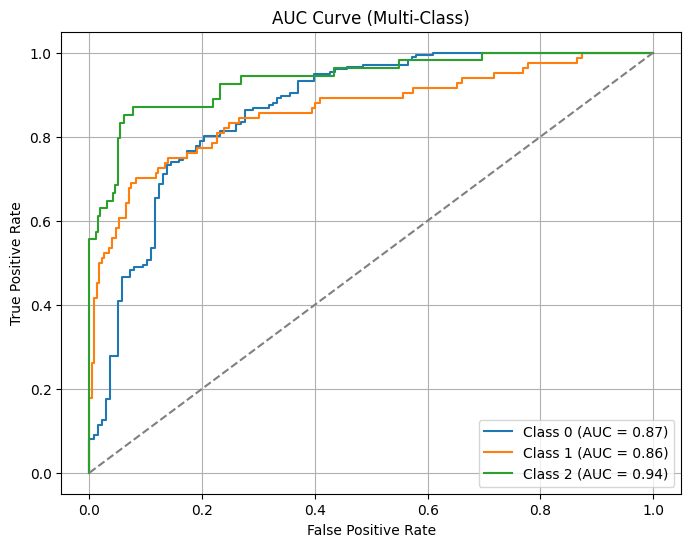

In [61]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ----------------------- AUC CURVE -----------------------

# Load test data and model predictions
y_true = []
y_pred_prob = []

classifier_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier_model(images)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()

        y_true.extend(labels.cpu().numpy())
        y_pred_prob.extend(probabilities)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Convert labels to one-hot encoding for multi-class AUC
num_classes = len(set(y_true))
y_true_bin = label_binarize(y_true, classes=range(num_classes))

# Plot AUC Curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Diagonal reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Curve (Multi-Class)")
plt.legend()
plt.grid(True)
plt.show()
